In [1]:
from importlib import reload
from PIL import Image
import os
import time
import numpy as np
import torch
import pandas as pd
nn = torch.nn
F = torch.nn.functional

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import utils
import train, metrics
from model import *

/data/vision/polina/users/clintonw/anaconda3/envs/cuda11/lib/python3.10/site-packages/tinycudann/modules.py:53: UserWarning: tinycudann was built for lower compute capability (60) than the system's (61). Performance may be suboptimal.
  warnings.warn(f"tinycudann was built for lower compute capability ({cc}) than the system's ({system_compute_capability}). Performance may be suboptimal.")


In [ ]:
# df = pd.read_csv('results/default.csv', index_col=0)
# sns.lineplot(data=df, x='size', y='psnr', hue='format');
# np.load('results/test.npy', allow_pickle=True).item()

In [2]:
# image_path = '../learnable_wavelet/data/train_gt.png'#'data/kodak/3.png'
# img = np.array(Image.open(image_path))[...,:3] / 255.
batch_size = 240_000

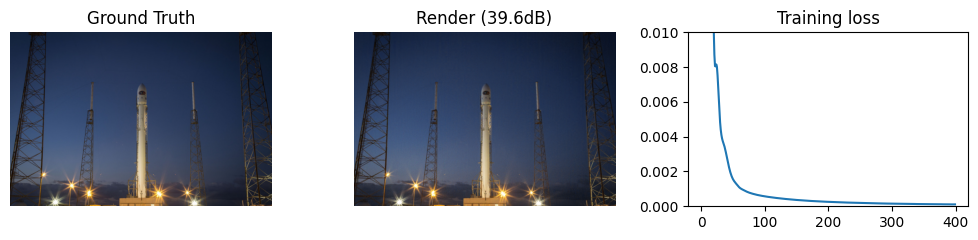

psnr=39.55475983520886, 56.2 seconds


In [36]:
# @title train baseline
results = pd.DataFrame(columns=['img_name', 'psnr', 'time'])
n_iters=400
R = 7
N = 2**14
feat_len = 2
for img_name in ['train', 'fern', 'coffee', 'nuts', 'rocket']:
    image_path = f'../learnable_wavelet/data/{img_name}_gt.png'
    img = np.array(Image.open(image_path))[...,:3].astype(float)# / 255.
    img /= img.max()
    losses = []
    model, optimizer = train.init_model(img, model_type='ngp', R=R, N=N, F=feat_len, lr=5e-3, min_resolution=32, max_resolution=512)#, resolution_feature_scaler=0.2)
    torch_img = torch.tensor(img).cuda()
    t0 = time.time()
    for iteration in range(n_iters):
        x = torch.rand((batch_size, 2), device='cuda')
        loss = ((model.render() - torch_img)**2).mean()
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        utils.plot(model, losses, img, iteration, plot_every=100)
    dt = time.time() - t0
    render = model.render(to_numpy=True)
    psnr = metrics.psnr(render, img)
    print(f'{psnr=}, {dt:.1f} seconds')
    results.loc[len(results.index)] = [img_name, psnr, dt]

In [3]:
tau = 3e1                   # Photon noise (max. mean lambda). Set to 3e7 for representation, 3e1 for denoising
noise_snr = 2               # Readout noise (dB)
def add_noise(x, noise_snr=40, tau=100):
    ''' Realistic sensor measurement with readout and photon noise

        Inputs:
            noise_snr: Readout noise in electron count
            tau: Integration time. Poisson noise is created for x*tau.
                (Default is 100)

        Outputs:
            x_meas: x with added noise
    '''
    x_meas = np.copy(x)
    noise = np.random.randn(x_meas.size).reshape(x_meas.shape)*noise_snr

    # First add photon noise, provided it is not infinity
    if tau != float('Inf'):
        x_meas = x_meas*tau

        x_meas[x > 0] = np.random.poisson(x_meas[x > 0])
        x_meas[x <= 0] = -np.random.poisson(-x_meas[x <= 0])

        x_meas = (x_meas + noise)/tau

    else:
        x_meas = x_meas + noise

    return x_meas


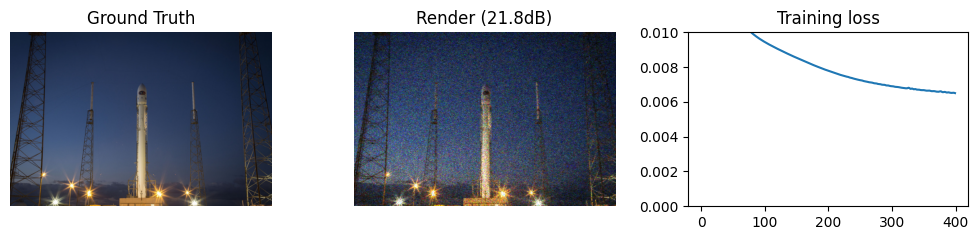

psnr=21.84203058918753, 55.8 seconds


In [11]:
# @title train denoise
results = pd.DataFrame(columns=['img_name', 'psnr', 'time'])
n_iters=400
R = 7
N = 2**14
feat_len = 2
for img_name in ['astronaut', 'cat', 'k5', 'k19', 'rocket']:
    image_path = f'../learnable_wavelet/data/{img_name}_gt.png'
    img = np.array(Image.open(image_path))[...,:3].astype(float)
    img /= img.max()
    noisy_img = np.clip(add_noise(img, noise_snr, tau), 0,1)
    losses = []
    model, optimizer = train.init_model(img, model_type='ngp', R=R, N=N, F=feat_len, lr=5e-3, min_resolution=32, max_resolution=512)#, resolution_feature_scaler=0.2)
    torch_img = torch.tensor(noisy_img).cuda()
    t0 = time.time()
    for iteration in range(n_iters):
        x = torch.rand((batch_size, 2), device='cuda')
        loss = ((model.render() - torch_img)**2).mean()
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        utils.plot(model, losses, img, iteration, plot_every=100)
    dt = time.time() - t0
    render = model.render(to_numpy=True)
    psnr = metrics.psnr(render, img)
    print(f'{psnr=}, {dt:.1f} seconds')
    results.loc[len(results.index)] = [img_name, psnr, dt]

In [13]:
# results.to_csv('results/ngp.csv')
results.to_csv('results/ngp_denoise.csv')

In [12]:
psnrs = []
times = []
for _,row in results.iterrows():
    psnrs.append(f"{row['psnr']:.2f}")
    times.append(f"{row['time']:.1f}")
print(' & '.join(psnrs))
print(' & '.join(times))

20.07 & 19.75 & 21.17 & 18.61 & 21.84
48.8 & 56.9 & 55.8 & 36.6 & 55.8


In [ ]:
# @title train VQRF
reload(train)
n_iters = 500
N = 2**8
feat_len = 4
losses = []
model, optimizer = train.init_model(img, model_type='vqrf', N=N, F=feat_len)
torch_img = torch.tensor(img).cuda()
for iteration in range(n_iters):
    x = torch.rand((batch_size, 2), device='cuda')
    loss = ((model(x) - utils.sample_img(torch_img, x))**2).mean()
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    utils.plot(model, losses, img, iteration, plot_every=100)

In [10]:
# @title train Compressed NGP
n_iters = 50
n_refinement_iters = 50
iteration_budget = n_iters + n_refinement_iters
R = 8
N = 2**10
F = 8
losses = []
model, optimizer = train.init_model(img, model_type='cngp', R=R, N=N, F=F, min_resolution=32, max_resolution=512, resolution_feature_scaler=0.1)
torch_img = torch.tensor(img).cuda()
for _ in range(n_iters):
    loss = ((model.render() - torch_img)**2).mean()
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    utils.plot(model, losses, img, plot_every=100)
torch.save({
    'model_state_dict': model.state_dict(),
    'losses': losses,
}, 'tmp.ckpt')
for _ in range(n_refinement_iters):
    loss = ((model.render() - torch_img)**2).mean()
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    utils.plot(model, losses, img, plot_every=100)
render = model.render(compress=True, to_numpy=True)
ngp_size = model.get_size()
ngp_psnr, ngp_ssim = metrics.psnr(render, img), metrics.ssim(render, img)

# compress and refine hash table
for buckets_per_feat in (8, 10):
    model.hashmap = None
    model.hash_features = nn.Parameter(torch.zeros_like(ckpt['model_state_dict']['hash_features']))
    ckpt = torch.load('tmp.ckpt')
    model.load_state_dict(ckpt['model_state_dict'])
    losses = ckpt['losses']
    quantized_feats, indices = model.quantize_table(buckets_per_feat)
    model.update_hash_feats(quantized_feats, indices)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(.9,.99), eps=1e-15)
    for _ in range(n_refinement_iters):
        loss = ((model.render() - torch_img)**2).mean()
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        utils.plot(model, losses, img, plot_every=100)
    render = model.render(compress=True, to_numpy=True)
    cngp_size = model.get_size()
    cngp_psnr, cngp_ssim = metrics.psnr(render, img), metrics.ssim(render, img)


tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 60. Falling back to CutlassMLP. For maximum performance, raise the target GPU architecture to 75+.
tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 60. Falling back to CutlassMLP. For maximum performance, raise the target GPU architecture to 75+.
tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 60. Falling back to CutlassMLP. For maximum performance, raise the target GPU architecture to 75+.
tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 60. Falling back to CutlassMLP. For maximum performance, raise the target GPU architecture to 75+.


In [ ]:
N = 2048
F = 4
n_iters = 1000
losses = []
plot_every = 100
model, optimizer = train.init_model(img, R=4, N=N, F=F, min_resolution=5, max_resolution=40)
torch_img = torch.tensor(img).cuda()
for iter in range(n_iters):
    loss = ((model.render() - torch_img)**2).mean()
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    utils.plot(model, losses, img, plot_every=100)

In [ ]:
reload(train);
model, optimizer = train.init_model(img, R=1, N=N, F=F, min_resolution=5, max_resolution=5)

In [6]:
coords = model.grid_coords()
for rix, res in enumerate(model.resolutions):
    x = coords * res
    x_ = torch.floor(x).long()
    w = x - x_
    x,y = x_[..., 0], x_[..., 1]
    break

In [ ]:
idx = torch.bitwise_xor(x, 2654435761*y) % self.N

In [56]:
ngp_render = model.render(compress=True, to_numpy=True)
ngp_size = model.get_size()
ngp_psnr, ngp_ssim = utils.psnr(ngp_render, img), utils.ssim(ngp_render, img)
print(ngp_psnr, ngp_size, model.get_hash_size())

31.783907975341496 69.0 64.0


In [57]:
# @title quantize hash features
# model.hash_features = nn.Parameter(old_hash_features)
# model.hashmap = None

F = model.hash_features.shape[-1]
buckets_per_feat=8
quantized_feats, indices = model.quantize_table(buckets_per_feat)
old_hash_features = model.hash_features.clone()
model.update_hash_feats(quantized_feats, indices)

In [120]:
reload(ngp);
#model.hash_features = nn.Parameter(old_hash_features)
F = model.hash_features.shape[-1]
buckets_per_feat = round(2**(15/F))
quantized_feats, indices = model.quantize_table(buckets_per_feat)
old_hash_features = model.hash_features
model.update_hash_feats(quantized_feats, indices)

In [14]:
model.scatter_entries()

In [ ]:
# @title refine remapped hash features
n_iters = 1000
plot_every = 100
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, betas=(.9,.99), eps=1e-15)
torch_img = torch.tensor(img).cuda()
for iter in range(n_iters):
    loss = ((model.render() - torch_img)**2).mean()
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if plot_every and (iter+1) % plot_every == 0:
        clear_output(wait=True)
        fig, axes = plt.subplots(1,3, figsize=(10, 3), tight_layout=True)
        axes[0].imshow(img)
        axes[0].set_axis_off()
        axes[0].set_title('Ground Truth')
        render = model.render(to_numpy=True)
        ngp_psnr, ngp_ssim = utils.psnr(render, img), utils.ssim(render, img)
        axes[1].imshow(render)
        axes[1].set_title(f'NGP ({ngp_psnr:.1f}dB)')
        axes[1].set_axis_off()
        axes[2].plot(losses)
        axes[2].set_ylim(0, 0.01)
        axes[2].set_title(f'Training loss')
        plt.show()

In [ ]:
comp_render = model.render(compress=True, to_numpy=True)
cngp_size = model.get_size()
cngp_psnr, cngp_ssim = utils.psnr(comp_render, img), utils.ssim(comp_render, img)
print(cngp_psnr, cngp_size, model.get_hash_size(), model.get_hashmap_size())

27.352930934418698 36.75 13.75 16.0


In [53]:
# reload(utils)
jpg, jpg_size = utils.to_jpg(Image.open(image_path), quality=60)
jpg_psnr, jpg_ssim = utils.psnr(jpg, img), utils.ssim(jpg, img)

In [ ]:
fig, axes = plt.subplots(1,4, figsize=(10, 3), tight_layout=True)
axes[0].imshow(img)
axes[0].set_title('Ground Truth')
axes[1].imshow(jpg)
axes[1].set_title(f'JPG ({jpg_psnr:.1f}dB, {jpg_size:.1f}kB)')
axes[2].imshow(render)
axes[2].set_title(f'iNGP ({ngp_psnr:.1f}dB, {ngp_size:.1f}kB)')
axes[3].imshow(comp_render)
axes[3].set_title(f'Compressed iNGP ({cngp_psnr:.1f}dB, {cngp_size:.1f}kB)')
for ax in axes.ravel():
    ax.set_axis_off()

In [ ]:
counts = torch.zeros(model.hash_features.shape[0]).cuda()
means = torch.zeros(model.hash_features.shape[0]).cuda()
M2 = torch.zeros(model.hash_features.shape[0]).cuda()

pixelwise_diffs = ((model.render() - torch_img)**2).mean(axis=-1).flatten()

for iteration in range(1000):#range(pixelwise_diffs.shape[0]):
    if (iteration+1) % 100 == 0:
        print(iteration+1)
    pixel = np.random.randint(0, pixelwise_diffs.shape[0])
    optimizer.zero_grad()
    pixelwise_diffs[pixel].backward(retain_graph=True)
    grad = torch.linalg.norm(model.hash_features.grad, dim=1)
    nonzero = grad != 0
    newvalue = grad[nonzero]
    counts[nonzero] += 1
    delta = newvalue - means[nonzero]
    means[nonzero] += delta / counts[nonzero]
    delta2 = newvalue - means[nonzero]
    M2[nonzero] += delta * delta2

In [124]:
variances = M2 / (counts - 1)
threshold = np.nanpercentile(variances.cpu().numpy(), 60)
high_var_mask = variances > threshold

In [126]:
buckets_per_feat = round(2**(12/F))
new_hash_features, new_indices = ngp.quantize_table(model.hash_features[high_var_mask], buckets_per_feat)
N_old = model.hash_features.shape[0]
N_new = new_hash_features.shape[0]
hash_feats = torch.cat((model.hash_features[~indices], new_hash_features))
new_hashmap = model.hashmap.clone()


In [ ]:
for i in range(N_old):
    if high_var_mask[i]:
        new_hashmap[new_indices[i]] = model.hashmap[i]
    else:
        new_hashmap = model.hashmap[]

In [ ]:
# @title plot NGP features
H,W = model.shape
x = torch.stack(torch.meshgrid(torch.linspace(0,1,H), torch.linspace(0,1,W), indexing='ij'), -1).reshape(-1,2)
feats = model.bilerp_hash(x)
feats = feats.reshape(H,W,-1)
feats = feats.detach().numpy()
feats = (feats - feats.min()) / (feats.max() - feats.min())

In [ ]:
r,c = 3,3
fig, axes = plt.subplots(r,c, figsize=(5, 3.5), tight_layout=True)
for i in range(R):
    rgb = np.stack((feats[...,i*2], feats[...,i*2+1], feats[...,i*2]), -1)
    axes[i//c, i%c].imshow(rgb)
    axes[i//c, i%c].set_axis_off()

In [ ]:
# fig, axes = plt.subplots(1,2, figsize=(7, 3), tight_layout=True)
# axes[0].imshow(img)
# axes[0].set_title('Ground Truth')
# axes[1].imshow(jpg)
# axes[1].set_title(f'JPG (PSNR={jpg_psnr:.1f}, Size={jpg_size:.1f}kB)')
# for ax in axes.ravel():
#     ax.set_axis_off()

In [ ]:
results = pd.read_csv('results.csv', index_col=0)
results.head()